In [1]:
import os
#os.environ['CUDA_VISIBLE_DEVICES']="1"

import matplotlib.pyplot as plt

from fastai import *
from fastai.vision import *
from fastai.callbacks import *
import pandas as pd
from arch import RingGeMNet, GeMNet, L2Norm, GeM
import re

from fastprogress import master_bar, progress_bar
%config InlineBackend.figure_format ='retina'

In [2]:
# ./index -> points to index dir
COMP_DATA_DIR = Path('.')

df = pd.DataFrame({'Image' : sorted(get_image_files(COMP_DATA_DIR / 'index', recurse=True))})

In [3]:
df.head()

Image
0  index/0/0/0/0000215a37942b17.jpg
1  index/0/0/0/00005baad2e46555.jpg
2  index/0/0/0/00007d3b7f15b575.jpg
3  index/0/0/0/00009069e8450638.jpg
4  index/0/0/0/00009574f46e9fd8.jpg

In [4]:
NUM_WORKERS=8
SIZE = 256
DO_FULL_SIZE = False 

class ImageListAbsPath(ImageList):
    def open(self, fn:PathOrStr)->Image:
        return open_image(fn.replace('./',''))
    
#tfms = get_transforms(do_flip=False)
tfms = (None, None)
if DO_FULL_SIZE:
    BS=1
    data = (ImageList.from_df(df,path='', cols=['Image'])
            .split_none()
            .label_const()
            .transform(tfms, resize_method=ResizeMethod.NO)
            .databunch(bs=BS, num_workers=NUM_WORKERS)
            .normalize(imagenet_stats)
           ) 
    data.train_dl.dl.batch_sampler.sampler = torch.utils.data.SequentialSampler(data.train_ds)
    data.train_dl.dl.batch_sampler.drop_last = False
if not DO_FULL_SIZE:
    BS=64
    data = (ImageList.from_df(df,path='', cols=['Image'])
            .split_none()
            .label_const()
            .transform(tfms, resize_method=ResizeMethod.SQUISH, size=SIZE)
            .databunch(bs=BS, num_workers=NUM_WORKERS)
            .normalize(imagenet_stats)
           ) 
    data.train_dl.dl.batch_sampler.sampler = torch.utils.data.SequentialSampler(data.train_ds)
    data.train_dl.dl.batch_sampler.drop_last = False

In [5]:
arch = models.resnet152 #models.densenet201
model_fname =  'resnet152_i200_l1000-256'
basename_suffix = 'cut-extractor-2scales6patches-gem3'
size_fname = 'full' if DO_FULL_SIZE else str(SIZE)

basename = f'{model_fname or arch.__name__}_{size_fname}_{basename_suffix}.pth'
print(basename)

resnet152_i200_l1000-256_256_cut-extractor-2scales6patches-gem3.pth


In [6]:
custom_head = nn.Sequential(
    #nn.AdaptiveMaxPool2d(1),
    Flatten(),
    L2Norm())

class Extractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.l2norm = L2Norm()
        self.pool   = GeM(3.) #nn.AdaptiveMaxPool2d(1)
    def forward(self, x):
        b,d,ny,nx = x.shape
        
        f0  = self.l2norm(self.pool(x)).view(b,1,d)
#        f0  = self.l2norm(self.pool(x)).view(b,d)
        
        #f1  = self.l2norm(self.pool(x[...,ny//2-ny//4:ny//2+ny//4,nx//2-nx//4:nx//2+nx//4])).view(b,1,d)

        #f1_x0y0 = self.l2norm(self.pool(x[...,:ny//2,:nx//2])).view(b,1,d)
        #f1_x0y1 = self.l2norm(self.pool(x[...,ny//2:,:nx//2])).view(b,1,d)
        #f1_x1y0 = self.l2norm(self.pool(x[...,:ny//2,nx//2:])).view(b,1,d)
        #f1_x1y1 = self.l2norm(self.pool(x[...,ny//2:,nx//2:])).view(b,1,d)
        
        #return torch.cat((f0,f1,f1_x0y0,f1_x0y1,f1_x1y0,f1_x1y1), dim=1)
        #return torch.cat((f0,f1), dim=1)
        
        return f0

In [7]:
arch

<function torchvision.models.resnet.resnet152(pretrained=False, progress=True, **kwargs)>

In [8]:
archcut = nn.Sequential(*list(arch(pretrained=True).children())[:-2],Extractor())

In [9]:
def cut_fn(x): 
    print(x)
    return True
TRAIN_CLASSES=1000
if False:
    learn = cnn_learner(data, arch,pretrained=True, custom_head=Extractor(),
                       metrics=[accuracy], cut= -1,
                       loss_func=nn.CrossEntropyLoss())

learn = Learner(data, archcut)



In [10]:
if model_fname:
    learn = learn.load(model_fname, strict=False)
else:
    model_fname = arch.__name__


/home/antor/miniconda3/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Extractor. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [11]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 128, 128]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 128, 128]       128        True      
______________________________________________________________________
ReLU                 [64, 128, 128]       0          False     
______________________________________________________________________
MaxPool2d            [64, 64, 64]         0          False     
______________________________________________________________________
Conv2d               [64, 64, 64]         4,096      True      
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
Conv2d               [64, 64, 64]         36,864     True      
______________________________________________________________

In [12]:
InferenceNet =  learn.model #Extractor(split_model_idx(learn.model, [-2])[0])

In [13]:
if False:
    data.batch_size = 2
    InferenceNet.eval()
    o = InferenceNet.forward(data.one_batch()[0].cuda())
    print(o.shape)

In [14]:
NUM_WORKERS=30

qdf = pd.DataFrame({'Image' : sorted(get_image_files(COMP_DATA_DIR / 'test', recurse=True))})
qdf.head()

Image
0  test/0/0/0/00016575233bc956.jpg
1  test/0/0/0/0001aadbcd8cb923.jpg
2  test/0/0/0/0002c06b2440a5f9.jpg
3  test/0/0/0/0002eb1ee5a5a6b2.jpg
4  test/0/0/0/000594dad986513e.jpg

In [15]:
BS=1 if DO_FULL_SIZE else 64
qdata = (ImageList.from_df(qdf,path='', cols=['Image'])
        .split_none()
        .label_const()
        .transform(tfms, 
                   resize_method=ResizeMethod.NO if DO_FULL_SIZE else ResizeMethod.SQUISH, 
                   size=None if DO_FULL_SIZE else SIZE)
        .databunch(bs=BS, num_workers=NUM_WORKERS)
        .normalize(imagenet_stats)
       ) 
qdata.train_dl.dl.batch_sampler.sampler = torch.utils.data.SequentialSampler(qdata.train_ds)
qdata.train_dl.dl.batch_sampler.drop_last = False

In [16]:
learn.model[8]

Extractor(
  (l2norm): L2Norm()
  (pool): GeM(p=3.0000, eps=1e-06)
)

In [17]:
basename

'resnet152_i200_l1000-256_256_cut-extractor-2scales6patches-gem3.pth'

In [18]:
i = next(iter(data.train_dl))[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


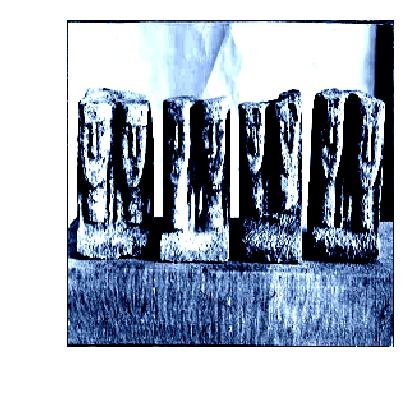

In [19]:
show_image(i.flip([3])[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


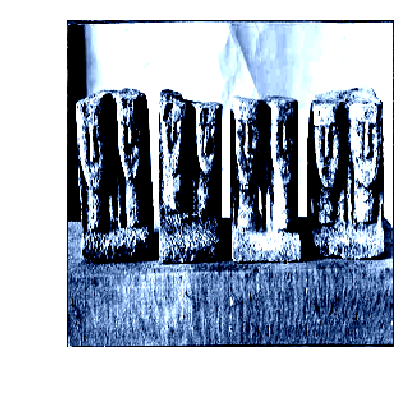

In [20]:
show_image(i[0])

In [21]:
def extract_vectors_batched(data,model,flip=False):
    model.cuda()
    model.eval()
    n_flip = 2 if flip else 1
    n_img = len(data.train_ds) * n_flip
    bs = data.batch_size
    vectors = None

    with torch.no_grad():
        for idx, (img,label) in enumerate(progress_bar(data.train_dl)):
            st=idx*bs*n_flip
            fin=min((idx+1)*bs*n_flip, n_img)
            if flip:
                img = torch.cat((img,img.flip([3])))
            out = model(img).cpu()
            if vectors is None: vectors = torch.zeros(n_img, *out.shape[1:])
            if flip:
                n = fin - st
                vectors[st:fin:2    ,...] = out[:n//2,...]
                vectors[st+1:fin+1:2,...] = out[n//2:,...]
            else:
                vectors[st:fin,...] = out
    return vectors

def extract_vectors_batched_multi(data,model):
    model.cuda()
    model.eval()
    n_img = len(data.train_ds)
    bs = data.batch_size
    vectors = None
    #hook = hook_outputs([learn.model[8]])#, learn.model[6]))
    
    #extractor = Extractor().cuda().eval()

    with torch.no_grad():
        for idx, (img,label) in enumerate(progress_bar(data.train_dl)):
            st=idx*bs
            fin=min((idx+1)*bs, n_img)
            layer_output = model(img).cpu()
            if vectors is None:
#                vectors = [torch.zeros(n_img, layer_output.shape[1]) for layer_output in hook.stored]
                vectors = torch.zeros(n_img, *layer_output.shape[1:]) 
            vectors[st:fin,...] = layer_output

            #for i, layer_output in enumerate(hook.stored):
            #    vectors[i][st:fin,...] = extractor(layer_output)
    return vectors

In [23]:
# change to load from disk or generate
flip = True
p_flip = 'flip' if flip else ''
if False:
    index_features = extract_vectors_batched(data, InferenceNet, flip)
    query_features = extract_vectors_batched(qdata,InferenceNet, flip)
    torch.save(query_features, f'query{p_flip}_{basename}')
    torch.save(index_features, f'index{p_flip}_{basename}')
else:
    query_features = torch.load( f'query{p_flip}_{basename}')
    index_features = torch.load( f'index{p_flip}_{basename}')

In [24]:
query_features, index_features

(tensor([[[2.8997e-04, 2.1737e-02, 1.7589e-02,  ..., 4.6509e-04,
           2.9025e-02, 1.0618e-02]],
 
         [[3.2344e-08, 2.4466e-02, 1.3500e-02,  ..., 3.2344e-08,
           4.2456e-02, 1.1022e-02]],
 
         [[1.5126e-02, 1.4514e-02, 1.2724e-02,  ..., 1.3823e-02,
           1.8042e-02, 4.1181e-02]],
 
         ...,
 
         [[3.4340e-02, 3.7003e-02, 3.6546e-03,  ..., 2.6789e-02,
           2.7013e-02, 5.5409e-03]],
 
         [[1.1022e-02, 9.2586e-03, 1.0880e-03,  ..., 2.6024e-02,
           1.9268e-02, 1.2435e-02]],
 
         [[5.3416e-03, 1.0505e-02, 2.8200e-04,  ..., 2.0615e-02,
           7.1443e-03, 9.0043e-03]]]),
 tensor([[[1.2256e-02, 7.6420e-02, 4.3411e-08,  ..., 2.8977e-02,
           3.8015e-02, 1.8919e-02]],
 
         [[2.0789e-02, 7.9405e-02, 4.4027e-08,  ..., 2.3203e-02,
           2.4790e-02, 1.7370e-02]],
 
         [[1.0051e-01, 1.1597e-02, 1.8086e-03,  ..., 2.0958e-02,
           5.7418e-02, 2.2582e-02]],
 
         ...,
 
         [[1.1883e-02, 5.2276e-0

In [25]:
#Now lets do the nearest neighbor search and create the submission
import faiss
def flatten(list2d): return list(itertools.chain(*list2d))

query_fnames = flatten([[x.stem, x.stem] for x in qdf.Image.tolist()])
index_fnames = flatten([[x.stem, x.stem] for x in df.Image.tolist()])


In [26]:
learn, InferenceNet, co, res, flat_config, cpu_index, index = None, None, None, None, None, None, None
gc.collect()
torch.cuda.empty_cache()

In [27]:
def t_pcawhitenlearn(X):

    N = X.shape[0]

    # Learning PCA w/o annotations
    m = X.mean(dim=0, keepdim=True)
    Xc = X - m
    Xcov = Xc.t() @ Xc
    Xcov = (Xcov + Xcov.t()) / (2*N)
    eigval, eigvec = torch.symeig(Xcov,eigenvectors=True)
    order = eigval.argsort(descending=True)
    eigval = eigval[order]
    eigvec = eigvec[:, order]

    P = torch.inverse(torch.sqrt(torch.diag(eigval))) @ eigvec.t()
    
    return m, P

def t_whitenapply(X, m, P, dimensions=None):
    
    if not dimensions: dimensions = P.shape[1]

    X = (X-m) @ P[:,:dimensions]
    X = X / (torch.norm(X, dim=1, keepdim=True) + 1e-6)
    return X

def get_idxs_and_dists(_query_features, _index_features, index_type='', BS = 32):
    
    if False:
        index_transforms = []
        for index_transform in index_type.split(','):
            m = re.match(r'PCAW(\d+)?', index_transform)
            if m is not None:
                dimensions = int(m[1]) if m[1] is not None else _index_features.shape[-1]
                print(f"Applying {dimensions} PCA, Whitening and L2Norm...", end="")
                m, P = t_pcawhitenlearn(_index_features)
                _index_features = t_whitenapply(_index_features, m, P,dimensions=dimensions).unsqueeze(1)
                _query_features = t_whitenapply(_query_features, m, P,dimensions=dimensions).unsqueeze(1)
                print("done")

            elif index_transform not in ['L2norm']: index_transforms.append(index_transform)

        index_type = ','.join(index_transforms)
        print(index_type)
    else:
         _index_features = _index_features.unsqueeze(1)
         _query_features = _query_features.unsqueeze(1)
        
    if isinstance(_query_features, Tensor): query_features = _query_features.numpy()
    if isinstance(_index_features, Tensor): index_features = _index_features.numpy()
    max_hits = 300
    
    n_patches = query_features.shape[1]
    n_queries = query_features.shape[0]

    if False:
        query_features = query_features[:,::n_patches,:].squeeze(1).copy()
#        query_features = query_features.reshape(-1,query_features_shape[2])
        index_features = index_features.reshape(-1,index_features.shape[2])
    else:
        query_features = query_features[:,::n_patches,:].squeeze(1).copy()
        index_features = index_features[:,::n_patches,:].squeeze(1).copy()    
        n_patches = 1

    print(query_features.shape, index_features.shape, n_queries, n_patches)
    
    flat_config = faiss.GpuIndexFlatConfig()
    flat_config.device = 0
    res = faiss.StandardGpuResources()
    co = faiss.GpuMultipleClonerOptions()
    co.shard=True
    co.shard_type=1
    co.useFloat16=True
    _index = faiss.index_factory(index_features.shape[1], index_type)#, faiss.METRIC_INNER_PRODUCT)
    try:
        index = faiss.index_cpu_to_all_gpus(_index,co=co) #
        print("Index in GPU")
    except:
        index = _index
        print("Index in CPU")
    print("Training index...", end="")
    index.train(index_features)
    print("done")
    print("Adding features to index...", end="")
    index.add(index_features)
    print("done")
    out_dists = np.zeros((len(query_features), max_hits), dtype=np.float32)
    out_idxs  = np.zeros((len(query_features), max_hits), dtype=np.int32)
    NUM_QUERY = len (query_features)
    for ind in progress_bar(range(0, len(query_features), BS)):
        fin = ind+BS
        if fin > NUM_QUERY: fin = NUM_QUERY
        q_descs = query_features[ind:fin]
        D, I = index.search(q_descs, max_hits)
        out_dists[ind:fin] = D
        out_idxs[ind:fin] = I // n_patches
    return out_idxs, out_dists

In [28]:
faiss.omp_get_max_threads()

16

In [29]:
query_features.shape

torch.Size([235154, 1, 2048])

In [ ]:
faiss.omp_set_num_threads(31)
index_type="PCAW2048,L2norm,Flat"
#index_type="IVF4096,PQ16"
#index_type="Flat"

#out_idxs, out_dists = get_idxs_and_dists(
#    torch.cat((query_features[0],query_features[1]),dim=-1).squeeze(1), 
#    torch.cat((index_features[0],index_features[1]),dim=-1).squeeze(1), BS = 32*4, index_type=index_type)

out_idxs, out_dists = get_idxs_and_dists(
    query_features.squeeze(1), 
    index_features.squeeze(1), BS = 32*4, index_type=index_type)

(235154, 2048) (1523514, 2048) 235154 1
Index in CPU
Training index...done
Adding features to index...done


In [32]:
np.sort(out_dists.reshape((-1,int(out_idxs.shape[1]*1))), axis=1)

array([[1.503912, 1.542817, 1.554212, 1.557771, ..., 1.722073, 1.722121, 1.722379, 1.722458],
       [1.522451, 1.545684, 1.546302, 1.580349, ..., 1.735136, 1.735886, 1.736419, 1.736525],
       [1.51332 , 1.528347, 1.528647, 1.534822, ..., 1.719642, 1.719655, 1.719941, 1.720052],
       [1.510748, 1.515029, 1.5181  , 1.526448, ..., 1.709208, 1.709267, 1.709482, 1.70965 ],
       ...,
       [1.488556, 1.514732, 1.518618, 1.557723, ..., 1.758246, 1.75833 , 1.758414, 1.758422],
       [1.463198, 1.485953, 1.492158, 1.527894, ..., 1.751449, 1.751659, 1.75189 , 1.752128],
       [1.681737, 1.684908, 1.693014, 1.702137, ..., 1.796362, 1.796443, 1.796457, 1.796527],
       [1.63702 , 1.644467, 1.660296, 1.665541, ..., 1.78833 , 1.788527, 1.788619, 1.788641]], dtype=float32)

In [33]:
sub_fname = 'test_submission.csv'
sample_df = pd.read_csv('test.csv')
sample_df['images'] = ''

In [36]:
out_idxs[0]//2, out_idxs[1]//2

(array([552602, 737484, 571954, 390931, ..., 547060, 237528, 267887,  98223], dtype=int32),
 array([ 41965, 552602,  41965, 238519, ..., 389454, 367293, 318931, 104468], dtype=int32))

In [46]:
i = 2
idx = np.concatenate([out_idxs[i], out_idxs[i+1]], axis=0)
dst = np.concatenate([out_dists[i],out_dists[i+1]], axis=0) 
u_idx = np.unique(idx,return_index=True)[1]
i_dst = dst[u_idx]
o_dst =np.argsort(i_dst)
print(idx, o_dst, i_dst)
print(idx[u_idx[o_dst]]//2)

i = 2
idx = np.concatenate([out_idxs[i], out_idxs[i+1]], axis=0)//2
dst = np.concatenate([out_dists[i],out_dists[i+1]], axis=0) 
u_idx = np.unique(idx,return_index=True)[1]
i_dst = dst[u_idx]
o_dst =np.argsort(i_dst)
print(idx, o_dst, i_dst)
print(idx[u_idx[o_dst]])

[ 644514   34021  803490  803491 ... 1231010  793135  455343   38283] [188   5 233 234 ... 350 243 302 334] [1.673222 1.680382 1.717505 1.701964 ... 1.710678 1.630177 1.698782 1.679552]
[322257  17010 401745 401745 ... 601172 412237 506464 561756]
[322257  17010 401745 401745 ... 615505 396567 227671  19141] [136   4 170  82 ... 273  52 258 243] [1.673222 1.680382 1.717505 1.701964 ... 1.632951 1.710678 1.698782 1.679552]
[322257  17010 401745 215476 ... 641582 128663 609517 561756]


In [64]:
sub = {}
for i, query_fname in progress_bar(enumerate(query_fnames), total=len(query_fnames)):
    #_out_idxs=out_idxs.reshape(-1,200)[i][np.unique(out_idxs.reshape(-1,200)[i],return_index=True)[1]]
    if i % 2: continue
    idx = np.concatenate([out_idxs[i], out_idxs[i+1]], axis=0)//2
    dst = np.concatenate([out_dists[i],out_dists[i+1]], axis=0) 
    u_idx = np.unique(idx,return_index=True)[1]
    i_dst = dst[u_idx]
    o_dst =np.argsort(i_dst)
    _out_idxs = idx[u_idx[o_dst]]

    #_out_idxs=out_idxs[i][np.unique(out_idxs[i],return_index=True)[1]]
    ids = [index_fnames[x*2] for x in _out_idxs[:100]]
    sub[query_fname] = ' '.join(ids)

In [65]:
sub_df = pd.DataFrame({'id' : list(sub.keys()), 'images':list(sub.values())})
sub_df = pd.concat([sub_df, sample_df]).drop_duplicates(subset=['id'])
sub_df.to_csv(sub_fname, index=False)

In [66]:
sub_df.iloc[:8]

id                                             images
0  00016575233bc956  b9dd41eb4f0c19ba f7cc17d847975d82 c05976a407e8...
1  0001aadbcd8cb923  6c4735c09a8db841 05c58f4fb9050b28 87150e29f954...
2  0002c06b2440a5f9  4e1a1aca112ccef8 ff59e4e0951042ff c5fcd16506f9...
3  0002eb1ee5a5a6b2  1806e66946f8614f db70274b4eab635b f12a4841fdfd...
4  000594dad986513e  7caded8ffd70960e b2d6c33f6d327a5c 1f7f47f1f5e4...
5  0006b7eb42bc7ee2  6a8ffc17c7fa420d 6d4942d04fa65827 503b1674bf29...
6  00084cdf8f600d00  f0b512f7a0bbd010 a15c36e05e3f4f2f bd1656c26b07...
7  0008722c48c52fda  1dc30a6266a4dd30 c05f0521c6ffef67 ecafd992eb1f...

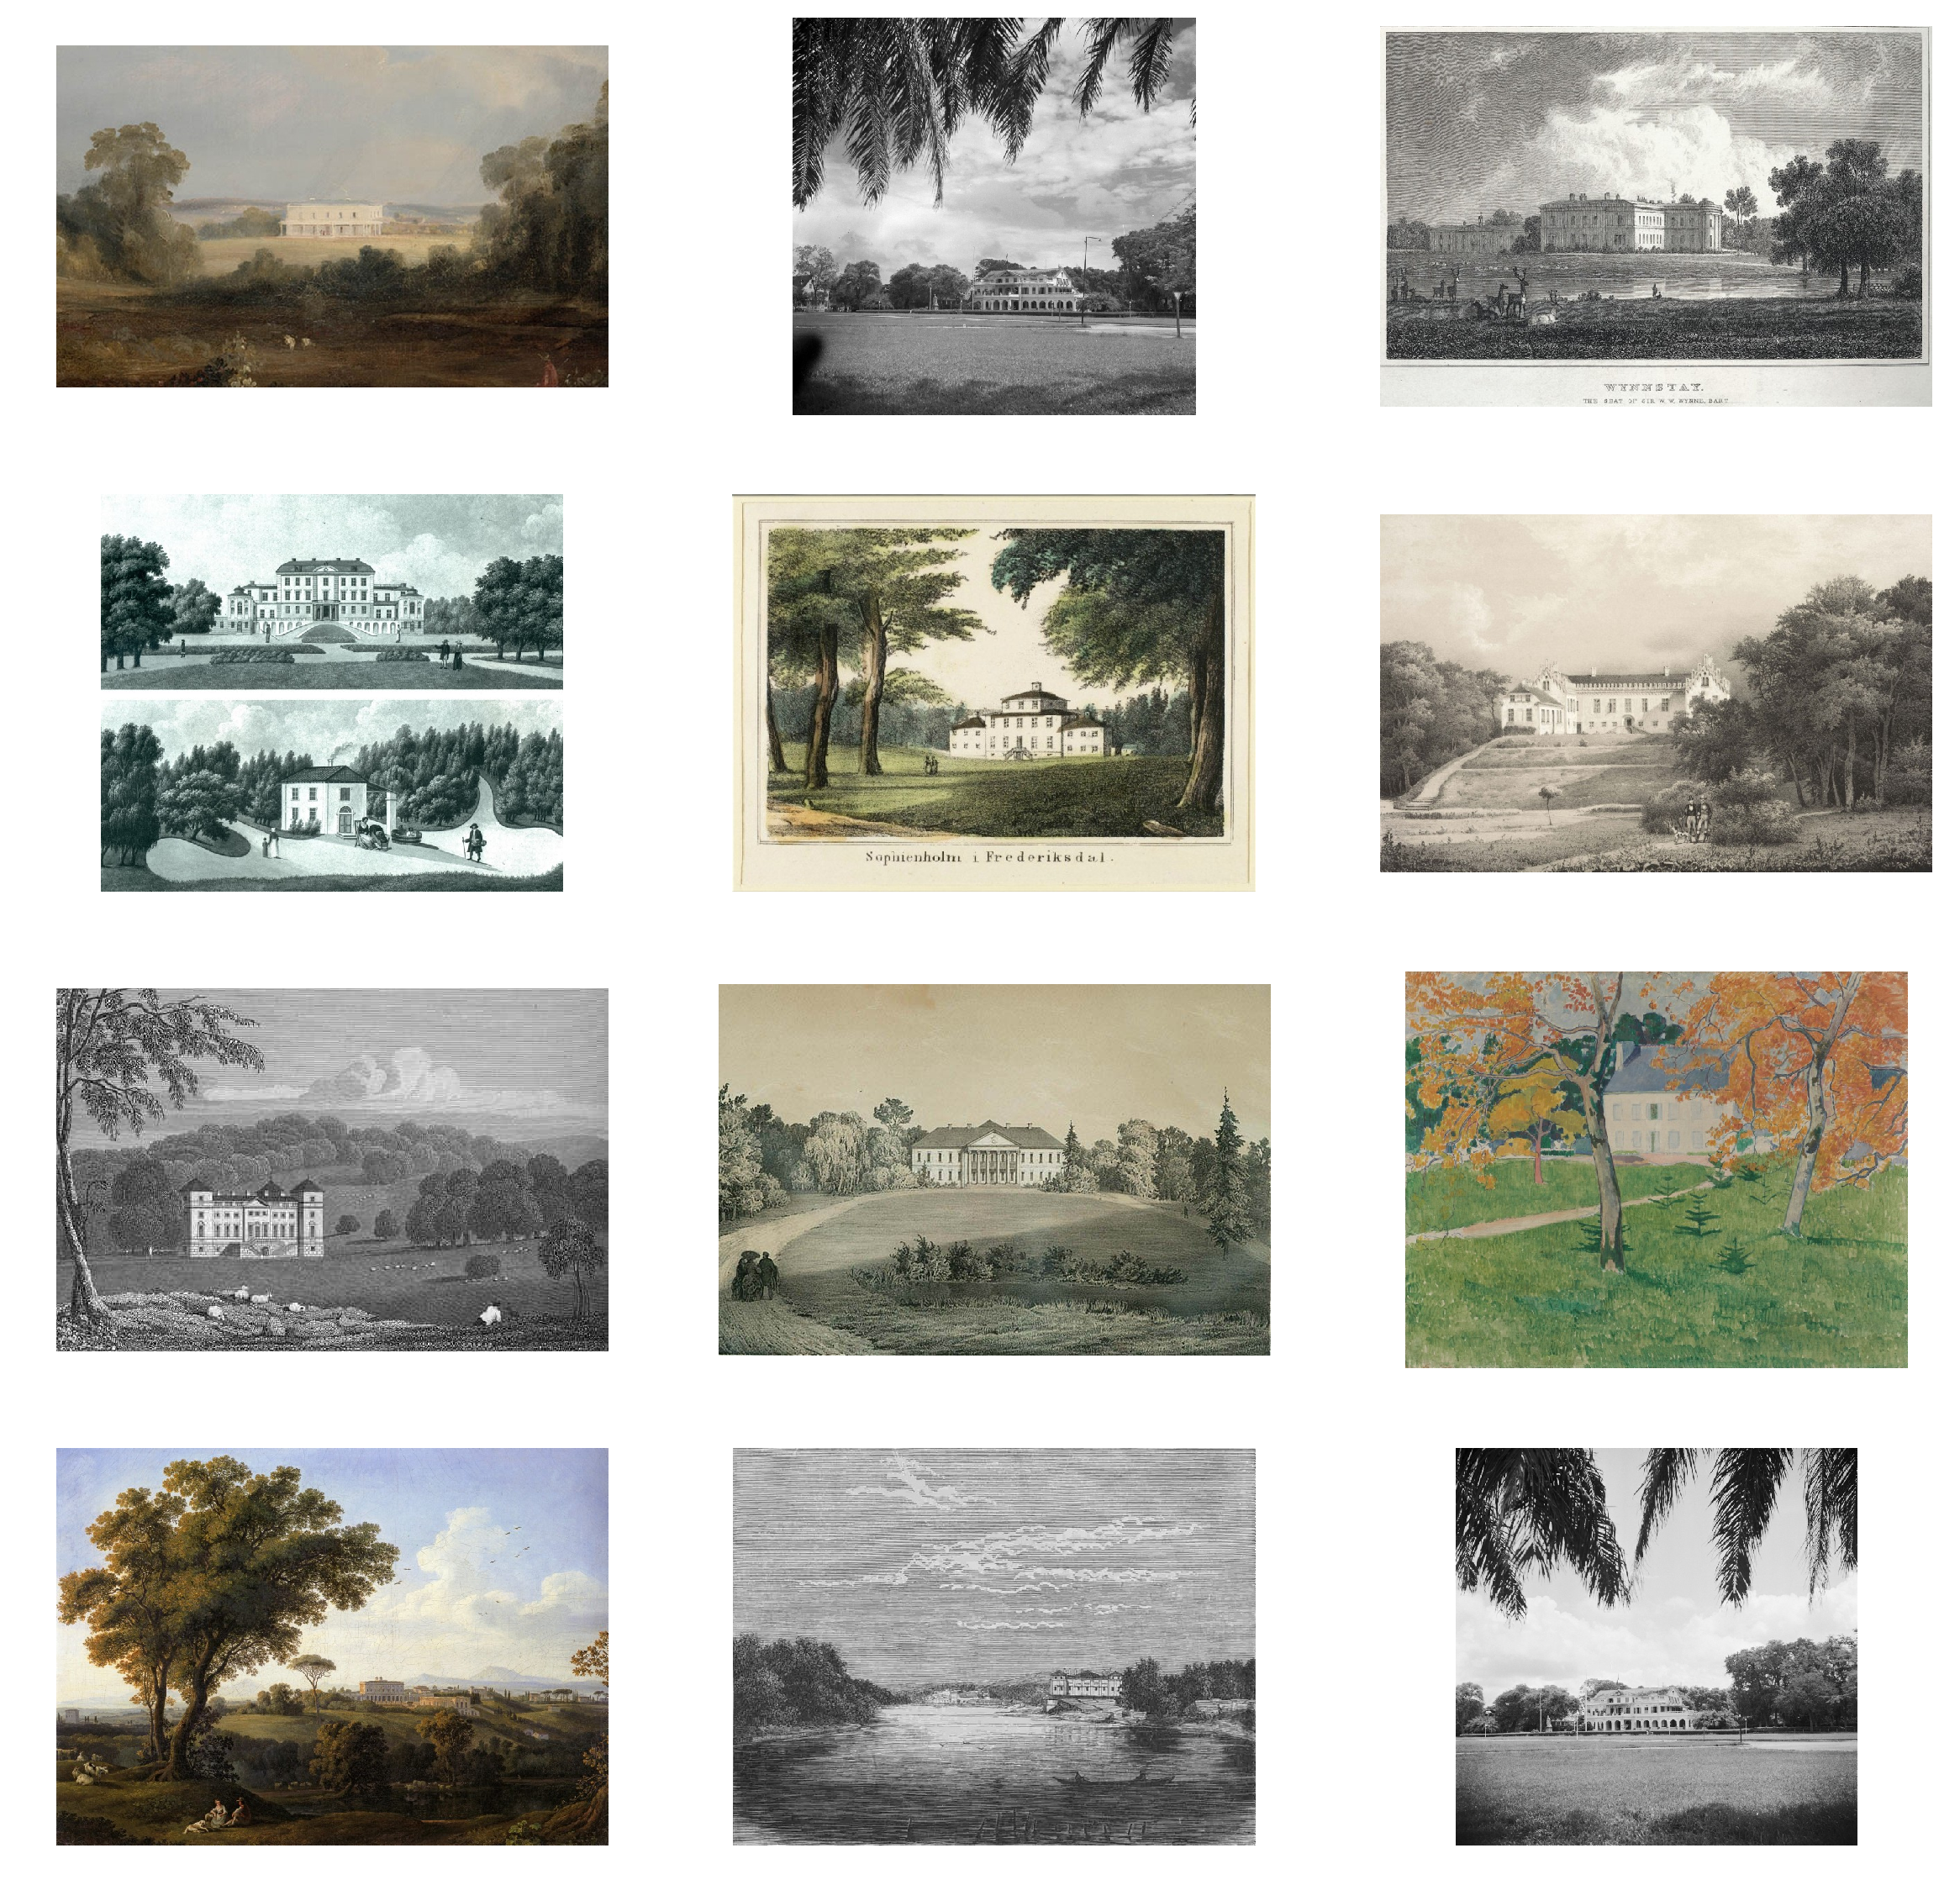

In [68]:
def fix_path(p):
    fn = str(p.name)
    return p.parent / fn[0] / fn[1] / fn[2] / fn
def image_results(row, n= 12):
    r = [open_image(fix_path(Path('test') / (row.id + '.jpg')))]
    r.extend([open_image(fix_path(Path('index') / (id + '.jpg'))) for id in row.images.split(' ')[:n]])
    return r
show_all(image_results(sub_df.iloc[0]),r=4,figsize=(20, 20))

In [69]:
basename

'resnet152_i200_l1000-256_256_cut-extractor-2scales6patches-gem3.pth'

In [70]:
!kaggle competitions submit -c landmark-retrieval-2019 -f {sub_fname} -m '{basename} {index_type}'

100%|████████████████████████████████████████| 193M/193M [00:07<00:00, 26.2MB/s]
Successfully submitted to Google Landmark Retrieval 2019

In [71]:
import time
time.sleep(10)

In [72]:
!kaggle competitions submissions -c landmark-retrieval-2019 -v > submissions.csv

In [73]:
submissions = pd.read_csv('submissions.csv')
submissions.iloc[0].publicScore

'0.06335'